In [1]:
from IPython.display import HTML
from IPython.display import Image

Magic the Gathering Card Recognition Project (Part 1): 
=============================
The Subgame
===============================================

<img src='Shahrazad.jpg' width="540" height="370" align="left"/>

**By: Pieter Leffers**,

*Starting Date: September 1, 2018*

*Completion Date: - -, 2018*

*Last Updated: Nov 28, 2018*

Part 1: Project Description
-----------------

For this first part of the project I a want to lay the ground-work for future pieces of the project. To start with I want to be able to take in a video, retrieve an image of a card from the video, store the image and marry it with a label, and identify portions of the card that would be useful for identification at a later time. To put it simply I want to be able to generate a dataset of images for training from video sources. Although this portion of the project isn't absolutely necessary since I have an abundance of images, information, and databases to pull information from; however, this part of the project basically contains most the elements I will need for future identification of the cards.

**Challenges**
1. Lighting has to be good
2. Video has to be almost flawless
3. Has to recognize the card images within glossly sleeves
4. The backgrounds have to vary in style 
5. The colors, text, backgrounds, and art can make identificaion of card boundaries particularly difficult to find


Data Source(s):
-----------
- Phone camera
- A Magic the Gathering tournament deck
- Describable textures dataset https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz


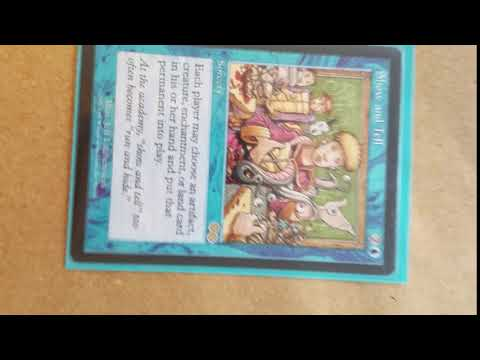

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("uHIOnX9ktjs")

In [3]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

**Import packages**


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import operator
from tqdm import tqdm
import random
import os, re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon

print('OpenCV Version:',cv2.__version__)

OpenCV Version: 3.4.3


In [3]:
def scrubadub(variable):
    myList=(list(variable))
    clean=[]
    for i in range(0,len(myList)):
        #Regular expressions for removing web addresses
        url_reg  = r'[a-z]*[:.]+\S+'
        #and replacing with nothing
        url_text=re.sub(url_reg, '', myList[i])
        sep = " "
        junk = re.findall(r"(?i)\b[a-z]+\b", url_text)
        #join the seperated words
        junk = sep.join(junk)
        #remove _s_ spaces from text after punctuation removal
        S_space = re.sub(r' s ',' ',junk)
        clean.append(S_space)
    return clean

In [4]:
CardNames=pd.read_json('data\\labels\\AllCards.json')
CardNames=CardNames.transpose() #Make the data columnar
CardNames=CardNames.reset_index() #Change names from index to a column in dataset
CardNames=CardNames.sort_values(by='index',ascending=True)
CardNames['index']=scrubadub(CardNames['index'])
CardNames['index']=CardNames['index'].str.replace(' ','_',regex=True)#Replace spaces with undercarriage
CardNames=list(CardNames['index'])#Make a list of the names

In [5]:
CardNames[:5]

['Ach_Hans_Run',
 'Rumors_of_My_Death',
 'World_Champion',
 'A_Display_of_My_Dark_Power',
 'A_Reckoning_Approaches']

Create a folder for each card

In [6]:
root_path=os.getcwd()+'\\data\\cards' #Assigned location for the cards folders

for name in CardNames:
#    print(name)
    try:
        os.mkdir(os.path.join(root_path,str(name)))
    except:
        continue

*Measurements on the cards*

Use a ruler to measure the dimensions as indicated in the image below. 
For the corner* measures, the idea is to delimit one rectangular zone that can hold the identifying marks. The size of the marks may vary with the printing, so take the measures on the cards with the widest, and tallest portions, and add one or two millimeters.

*Measures*

Report the measures in mm in the cell below (and don't forget to run the cell).

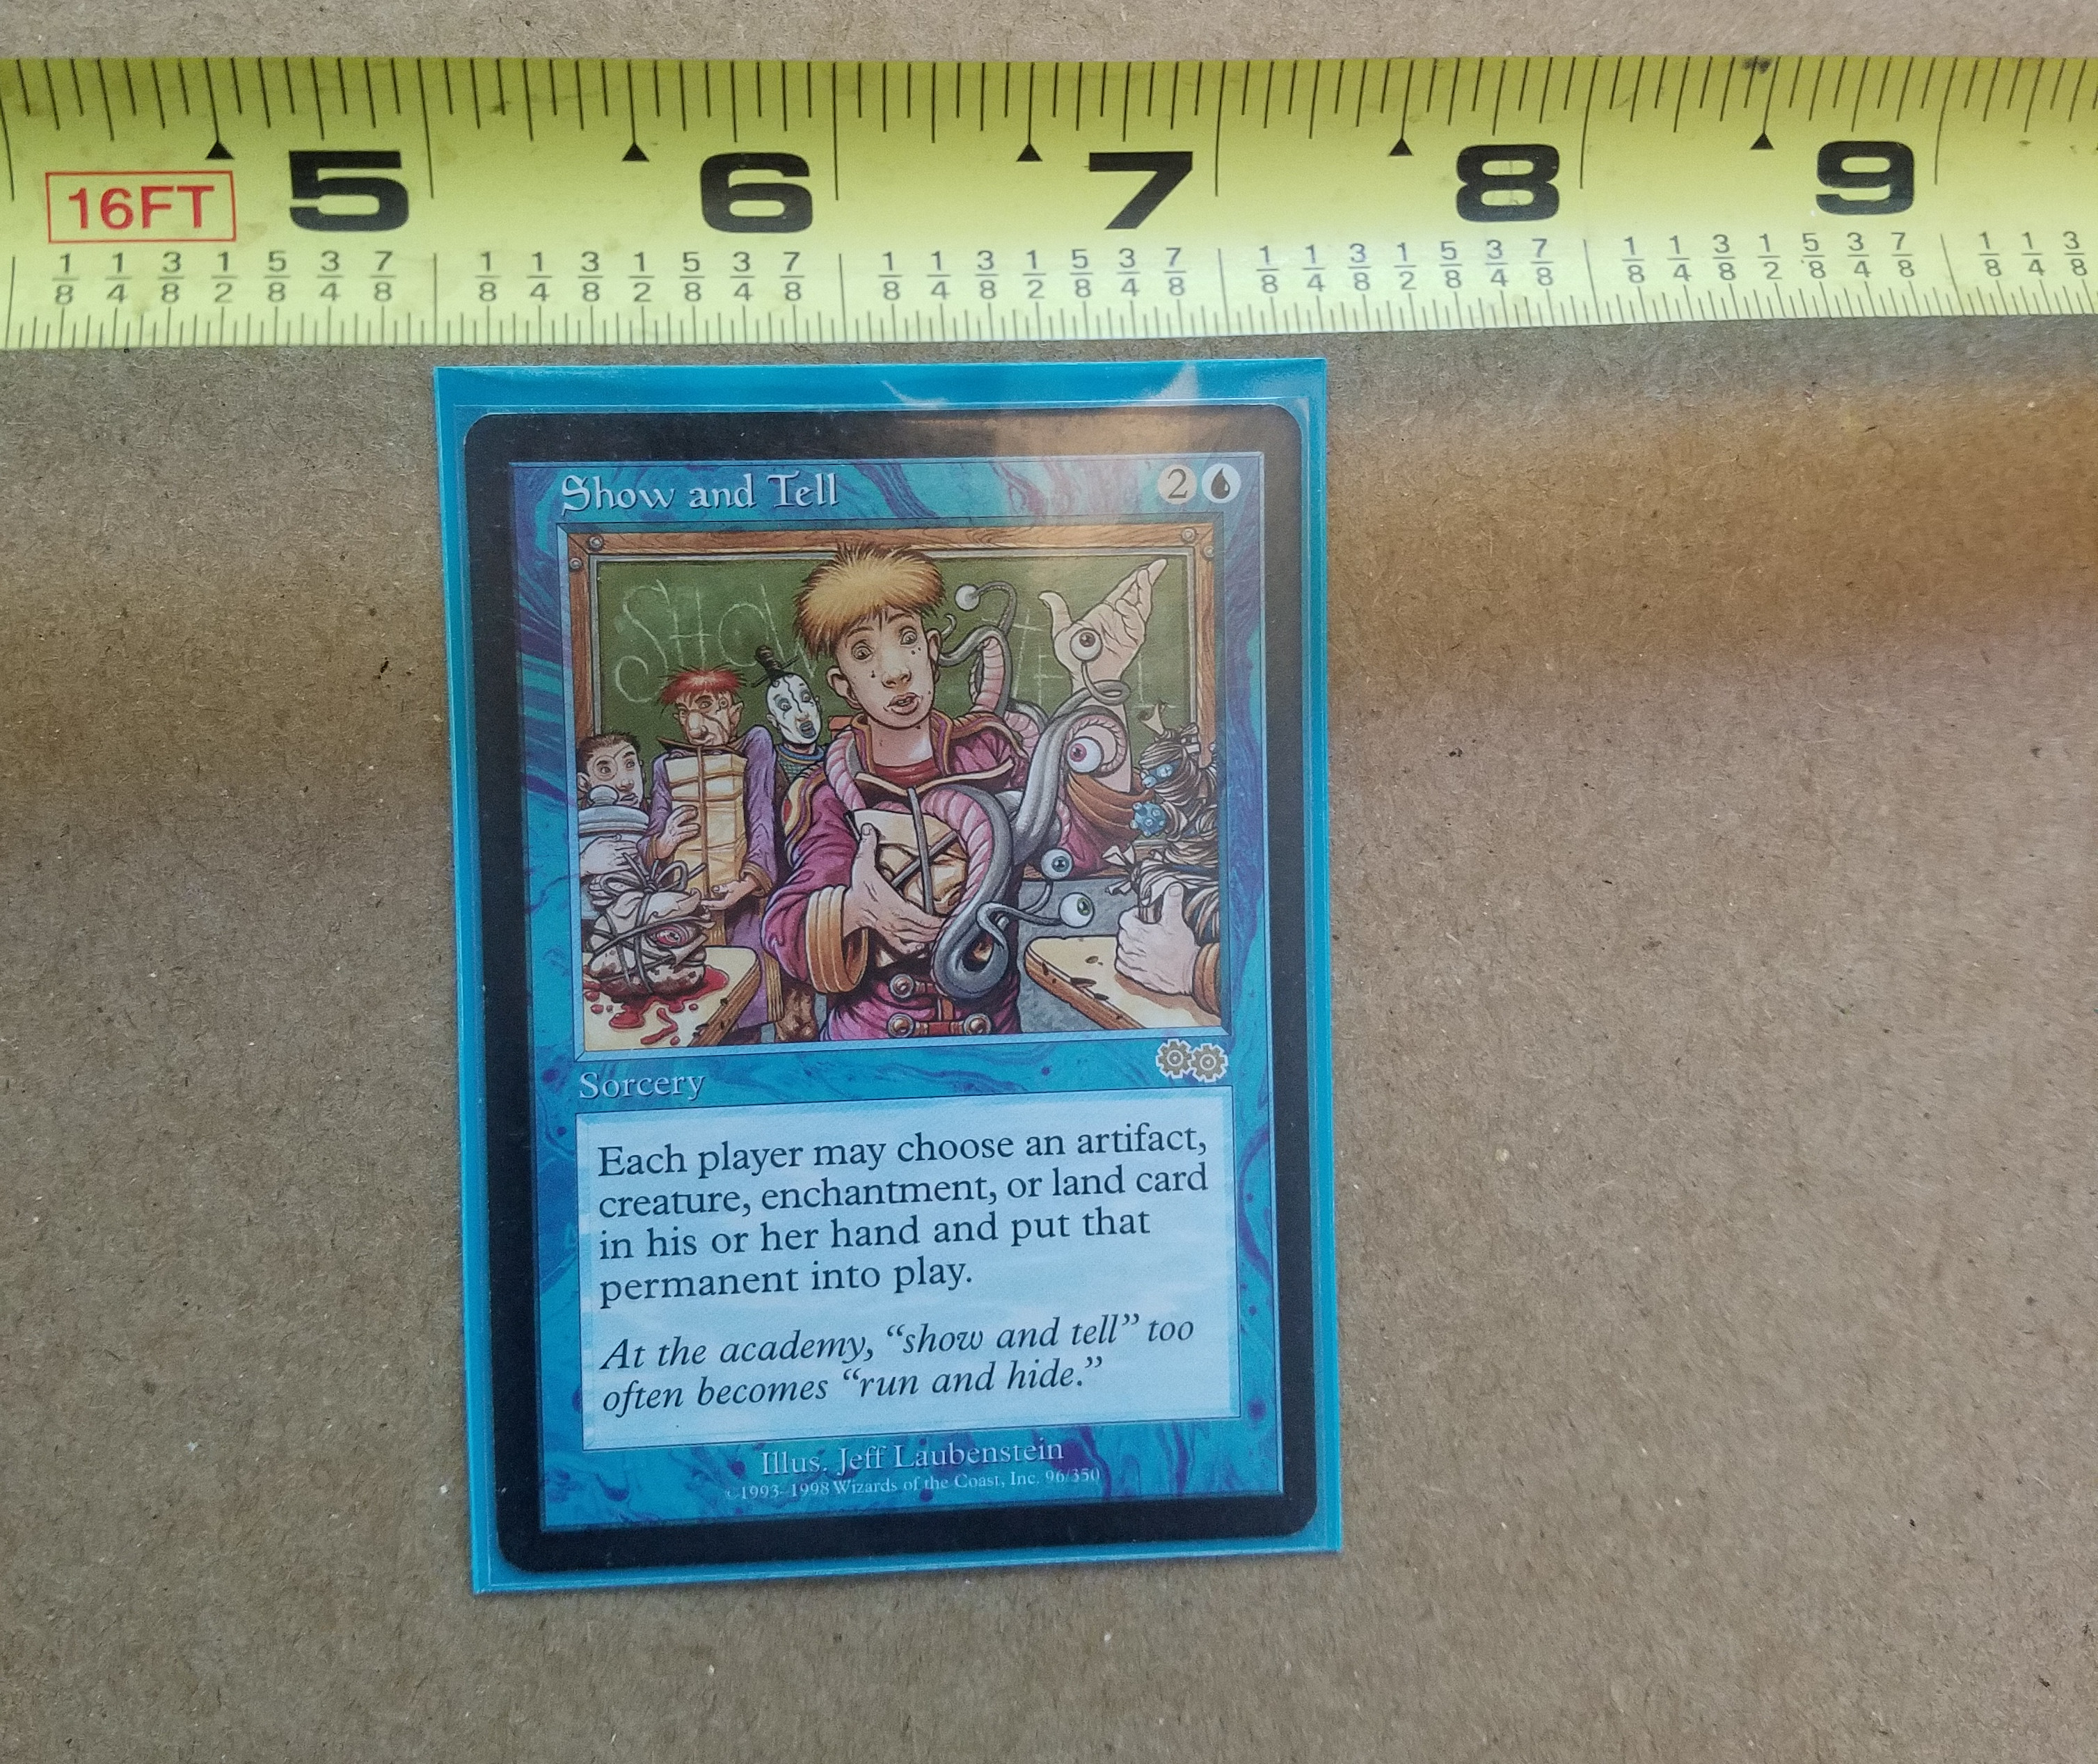

In [7]:
#Card Width
cardW=57 
Image("Width.jpg")

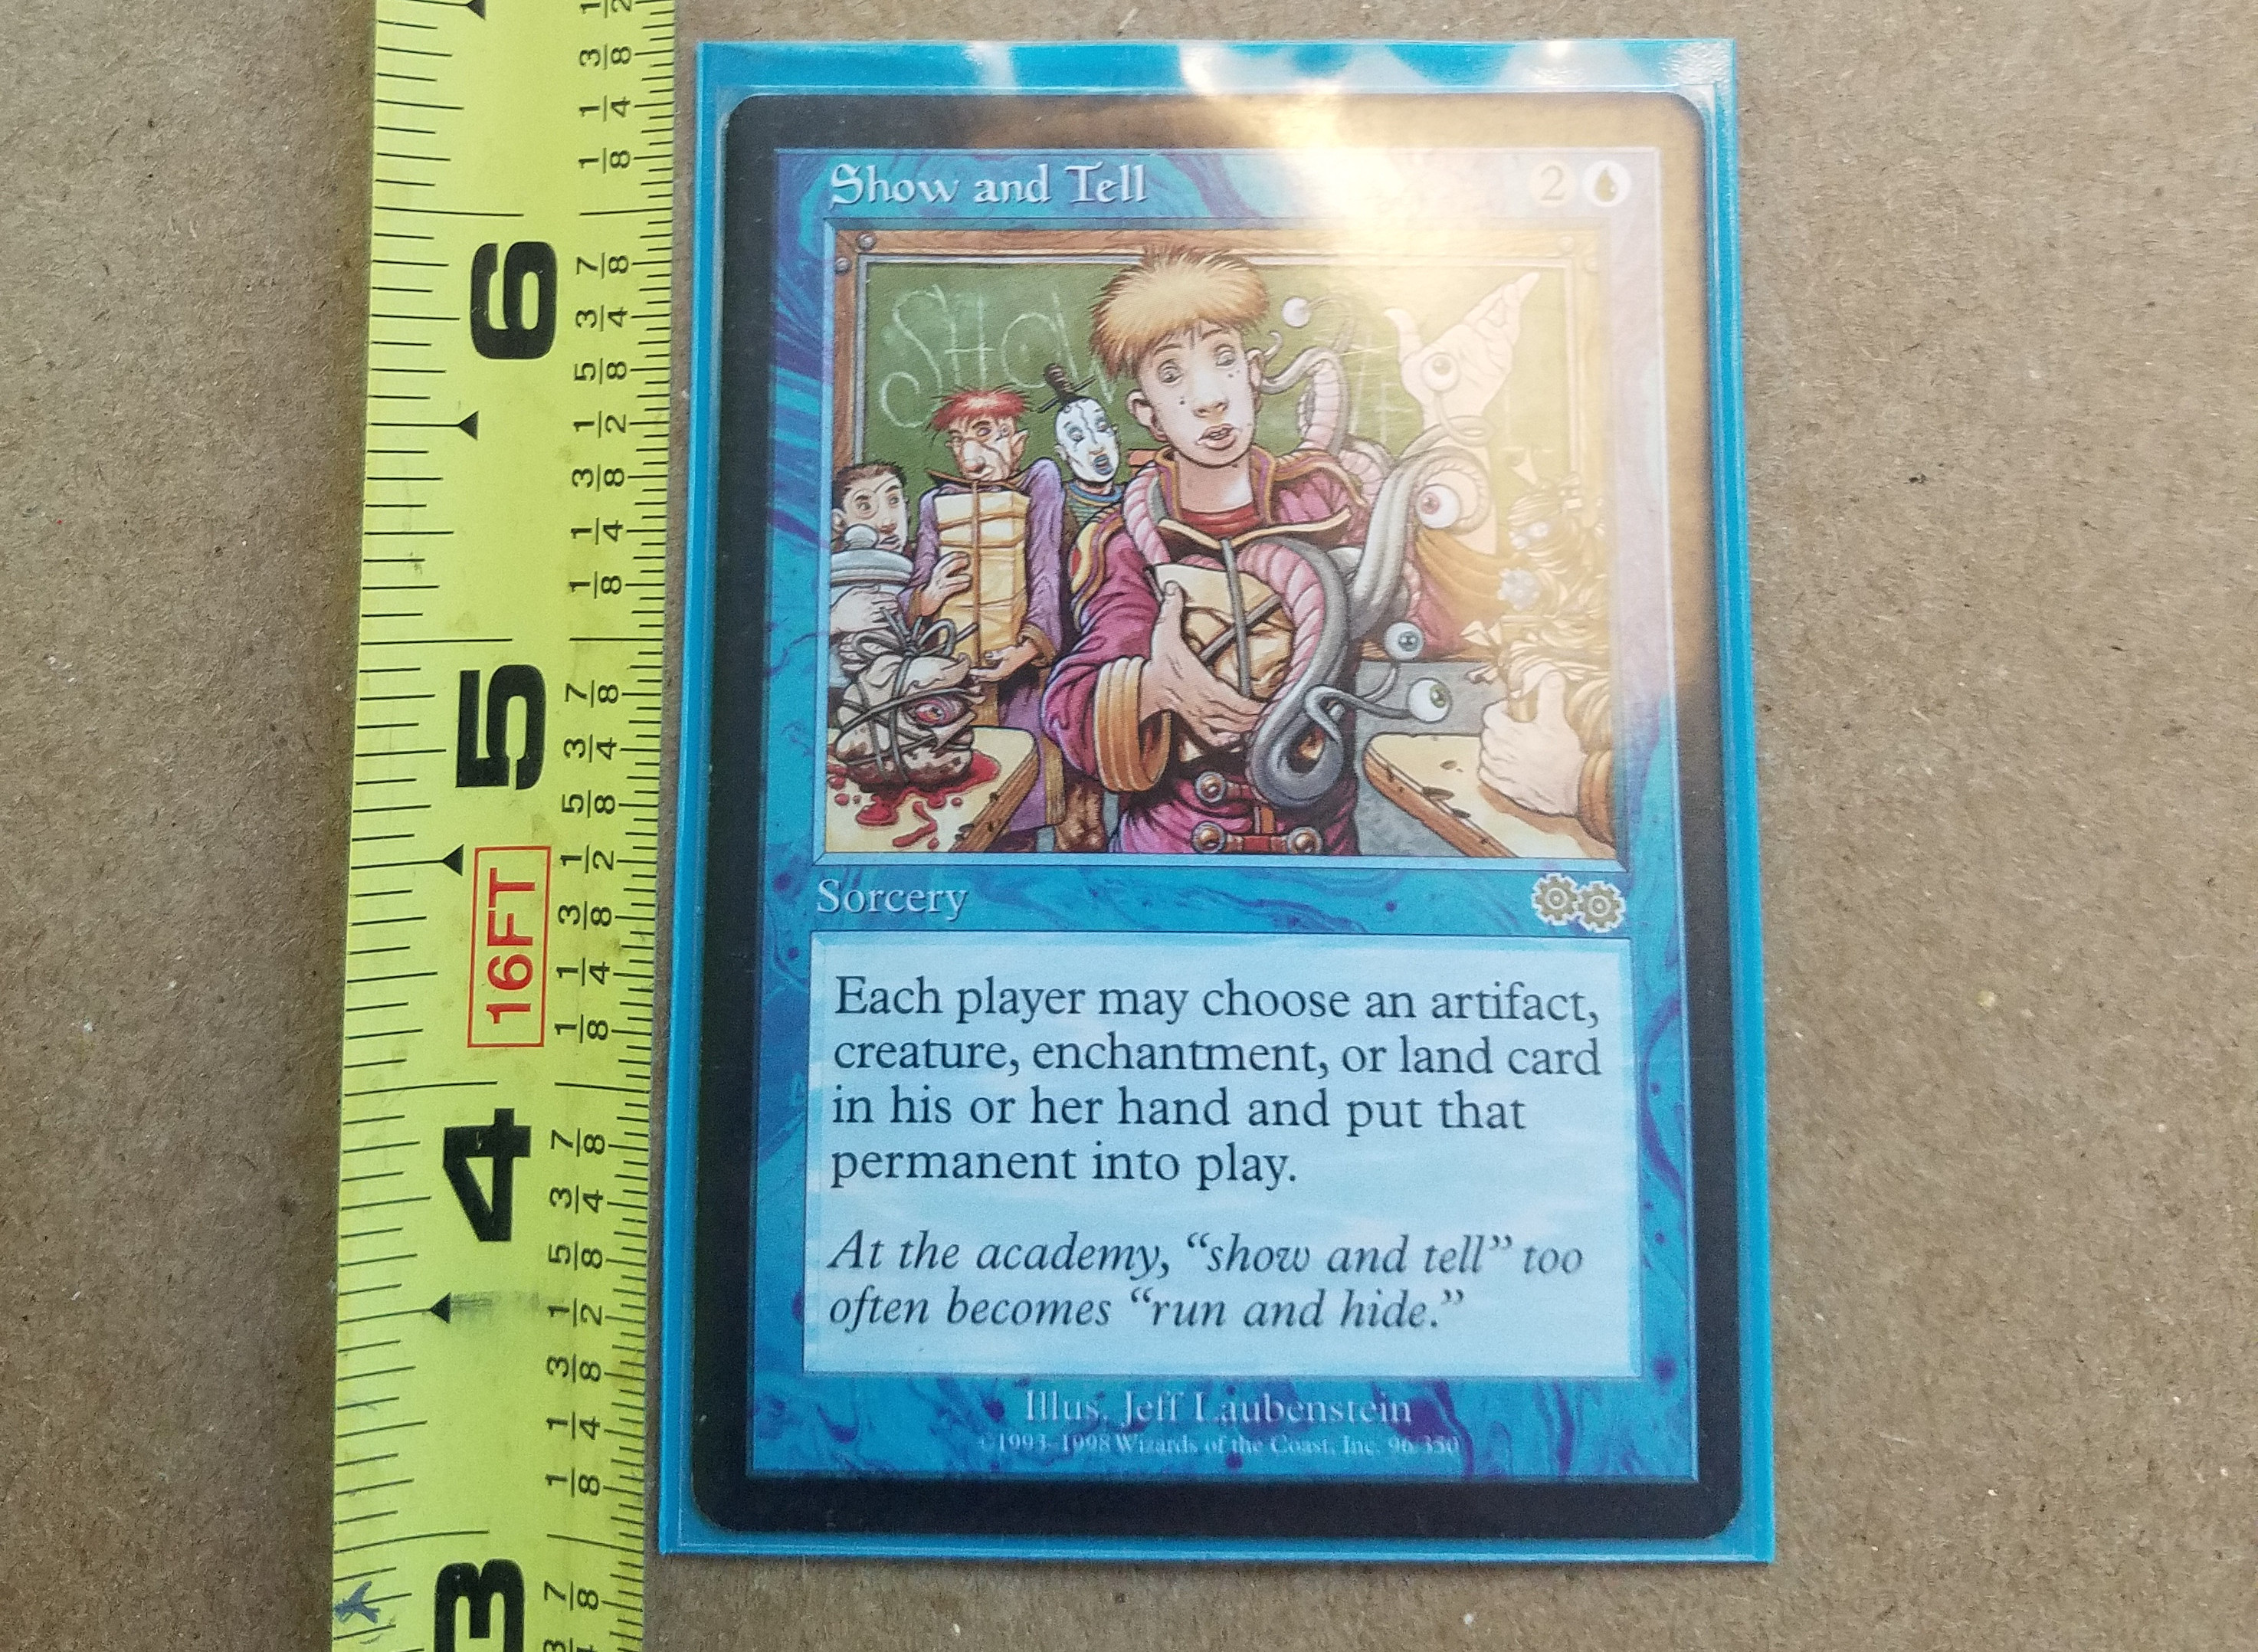

In [8]:
#Card Height
cardH=87 
Image("Height.jpg")

In [9]:
cornerXmin=5
cornerXmax=52
cornerYmin=4
cornerYmax=18

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
# You shouldn't need to change this
zoom=4
cardW*=zoom #228
cardH*=zoom #348
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

Global variables
---------------

In [10]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

names=CardNames

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"\\backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"\\cards.pck"

# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720

#https://math.stackexchange.com/questions/1764314/get-vertex-points-of-transformed-rectangle-knowing-bounding-box-and-transform-ma
#Card Dimensions
refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])


**Convenient Functions**

In [11]:
def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    try:
        for polygon in polygons:
            # An polygon has either shape (n,2), 
            # either (n,1,2) if it is a cv2 contour (like convex hull).
            # In the latter case, reshape in (n,2)
            if len(polygon.shape)==3:
                polygon=polygon.reshape(-1,2)
            patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
            ax.add_patch(patch)
    except:
        print(img)
        
def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
            > give_me_filename("dir","jpg", prefix="prefix")
            'dir/prefix408290659.jpg'
            > give_me_filename("dir",["jpg","xml"])
            ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames


** Get Describable Textures Dataset (DTD)**

A convenient way to generate backgrounds for the images of the cards dataset

**Download DTD (1x)**

In [12]:
#!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

**Extract the DTD (1x)**

In [13]:
#!tar xf dtd-r1.0.1.tar.gz

**Load all *jpg from dtd subdirectories and save them in a pickle file (1x)**

The next times, we will directly load the pickle file 

In [14]:
print(backgrounds_pck_fn)

data\backgrounds.pck


In [15]:
dtd_dir="dtd\\images\\"
bg_images=[]
for subdir in glob(dtd_dir+"\\*"):
    for f in glob(subdir+"\\*.jpg"):
        bg_images.append(mpimg.imread(f))
print("Number of images loaded :",len(bg_images))
#pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'),protocol=2)#python2 
pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))#python3
print("Saved in :",backgrounds_pck_fn)#backgrounds_pck_fn


Number of images loaded : 5640
Saved in : data\backgrounds.pck


In [16]:
# Clean-up
#!rm -r dtd
#!rm dtd-r1.0.1.tar.gz

### Load the backgounds pickle file in 'backgrounds'
'backgrounds' is an instance of the class Backgrounds
To get a random background image, call the method : backgrounds.get_random

In [17]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()

Nb of images loaded : 5640


In [18]:
#backgrounds = Backgrounds()

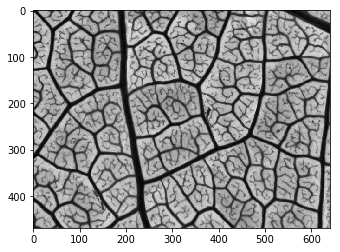

In [36]:
# Test: display a random background
_=backgrounds.get_random(display=True)

Extraction of the cards from pictures or video 
------------------------------------------

### Define the alphamask
The alphamask has 2 purposes:
- clean the border of the detected cards,
- make that border transparent. Cards are not perfect rectangles because corners are rounded. We need to make transparent the zone between the real card and its bounding rectangle, otherwise this zone will be visible in the final generated images of the dataset


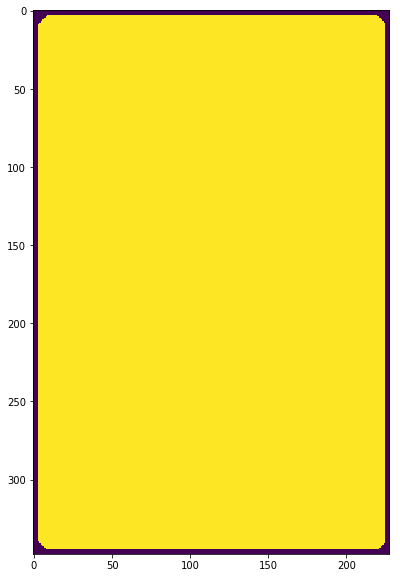

In [37]:
bord_size=3 # bord_size alpha=0
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

In [38]:
#alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255

In [39]:
alphamask.shape

(348, 228)

## Function extract_card 
Extract from scene image (cv2/bgr) the part corresponding to the card and transforms it 
to fit into the reference card shape.
We suppose here that the user facilitates as much as he can the extraction task by
making the scene image simple (one card on uniform backgroung, not too blurry, correct lighting,...)

In [40]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

Focus : 142.02487036297723 > 120


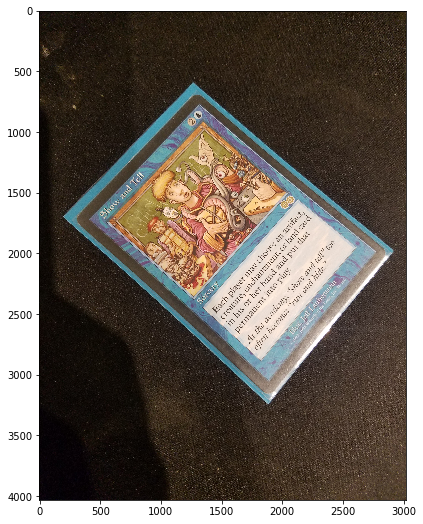

In [41]:
img=cv2.imread("data\\test\\2_142.jpg")
imgwarp=None
min_focus=120
# Check the image is not too blurry
focus=varianceOfLaplacian(img)
if focus < min_focus: 
    print("Focus too low :",focus,'<',min_focus)
else:
    print("Focus :",focus,'>',min_focus)
    display_img(img)

In [42]:
def extract_card (img, output_fn=None, min_focus=120, debug=False):
    """
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    #https://www.pyimagesearch.com/2014/04/21/building-pokedex-python-finding-game-boy-screen-step-4-6/
    #img = cv2.imread('data/test/3_131.jpg')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    bilateral=cv2.bilateralFilter(gray,11,17,17)

    medBlur = cv2.medianBlur(bilateral,5)

    ret,thresh = cv2.threshold(medBlur,130,255,cv2.THRESH_BINARY)
    #th3 = cv2.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
    edge=cv2.Canny(thresh,30,200)

    # find contours in the edged image, keep only the largest
    # ones, and initialize our screen contour
    _,contours, hierarchy = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key = cv2.contourArea, reverse = True)

    contidict={}   
    validict={}
    boxDict={}
    rectDict={}
    # loop over our contours save values into a dict to retrieve the maximum
    for c in range(0,len(cnts)):
        rect=cv2.minAreaRect(cnts[c])
        rectDict[c]=rect
        box=cv2.boxPoints(rect)
        box=np.int0(box)
        boxDict[c]=box
        areaCnt=cv2.contourArea(cnts[c])
        areaBox=cv2.contourArea(box)
        contidict[c]=areaBox
        try:
            valid=areaCnt/areaBox>0.95
            validict[c]=valid
        except:
            validict[c]=False


    #print(valid,':',areaCnt/areaBox)     
    maxarea=max(contidict.items(), key=operator.itemgetter(1))[0]
        
    if validict[maxarea]:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rectDict[maxarea]
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(boxDict[maxarea]),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(boxDict[maxarea]),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)

        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnts[maxarea].reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int)

        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)

        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)

        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel

        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)

    if debug:
        #cv2.imshow("Gray",gray)
        plt.imshow(gray)
        #cv2.imshow("Canny",edge)
        plt.imshow(edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[boxDict[maxarea]],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnts[maxarea]],0,(0,255,0),-1)
        #cv2.imshow("Contour with biggest area",edge_bgr)
        plt.imshow(edge_bgr)
        
        if validict[maxarea]:
            #cv2.imshow("Alphachannel",alphachannel)
            plt.imshow(alphachannel, dtype = np.uint8)
            #cv2.imshow("Extracted card",imgwarp)
            plt.imshow(imgwarp)

    return valid,imgwarp

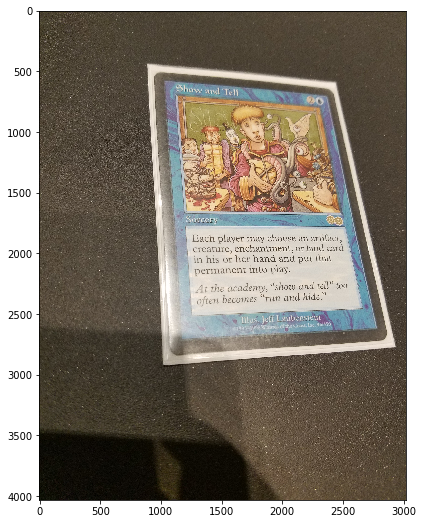

In [43]:
# Test on one image
debug=False
img=cv2.imread("data\\test\\3_131.jpg")
display_img(img)
valid,card=extract_card(img,"data\\test\\extracted_card.png", debug=debug, min_focus=60)
if valid:
    display_img(card)
if debug:
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Function extract_cards_from_video
-----------------

In [44]:
def extract_cards_from_video(video_fn, output_dir=None, keep_ratio=5, min_focus=120, debug=False):
    """
        Extract cards from media file 'video_fn' 
        If 'output_dir' is specified, the cards are saved in 'output_dir'.
        One file per card with a random file name
        Because 2 consecutives frames are probably very similar, we don't use every frame of the video, 
        but only one every 'keep_ratio' frames
        
        Returns list of extracted images
    """
    #Check to see if the file specified is in the file path
    if not os.path.isfile(video_fn):
        print("Video file",video_fn,"does not exist !!!")
        return -1,[]
    #If the object output_dir has a value then change to match
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cap=cv2.VideoCapture(video_fn)
    
    frame_nb=0
    imgs_list=[]
    while True:
        ret,img=cap.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                output_fn=give_me_filename(output_dir,"png")
            else:
                output_fn=None
            valid,card_img = extract_card(img,output_fn,min_focus=min_focus,debug=debug)
            if debug: 
                k=cv2.waitKey(1)
                if k==27: break
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    
    if debug:
        cap.release()
        cv2.destroyAllWindows()
    
    return imgs_list

In [46]:
# Test card extraction from a video   
imgs=extract_cards_from_video("data\\video\\Brainstorm.mp4",output_dir="data\\cards\\Brainstorm",debug=False)
print("Number images extracted:",len(imgs))

Number images extracted: 22


Card extraction from all the videos
--------------
We suppose we have for each card_name (ex: 2d, Kc, Ah) one video file named 'card_name.extension' (ex: 2d.avi, Kc.avi, Ah.avi) in a common directory (ex: data/video). If you use images instead of movies, the script below should work by setting the variable 'extension' below to "jpg" or "png". 
The cards from a video, or the card from an image, will be extracted in a subdirectory named 'card_name' placed in the directory 'imgs_dir' (ex: data/cards)

In [47]:
#For 18,000 cards this can take awhile
video_dir="data\\video"
extension="mp4"
imgs_dir="data\\cards"

for name in CardNames:
        card_name=name
        video_fn=os.path.join(video_dir,card_name+"."+extension)
        output_dir=os.path.join(imgs_dir,card_name)
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        imgs=extract_cards_from_video(video_fn,output_dir, min_focus=120)
        #print("Extracted images for %s : %d"%(card_name,len(imgs)))

Video file data\video\Ach_Hans_Run.mp4 does not exist !!!
Video file data\video\Rumors_of_My_Death.mp4 does not exist !!!
Video file data\video\World_Champion.mp4 does not exist !!!
Video file data\video\A_Display_of_My_Dark_Power.mp4 does not exist !!!
Video file data\video\A_Reckoning_Approaches.mp4 does not exist !!!
Video file data\video\AWOL.mp4 does not exist !!!
Video file data\video\Abandon_Hope.mp4 does not exist !!!
Video file data\video\Abandon_Reason.mp4 does not exist !!!
Video file data\video\Abandoned_Outpost.mp4 does not exist !!!
Video file data\video\Abandoned_Sarcophagus.mp4 does not exist !!!
Video file data\video\Abattoir_Ghoul.mp4 does not exist !!!
Video file data\video\Abbey_Gargoyles.mp4 does not exist !!!
Video file data\video\Abbey_Griffin.mp4 does not exist !!!
Video file data\video\Abbey_Matron.mp4 does not exist !!!
Video file data\video\Abbot_of_Keral_Keep.mp4 does not exist !!!
Video file data\video\Abduction.mp4 does not exist !!!
Video file data\video\

Before going on, check that everything looks good
---------------------
We randomly choose and display one of the extracted card. We also draw on the card the 2 polygons defined by refCornerHL and refCornerLR. Check that the value and suit symbols are well inside the polygons. If not, check the hand-made measures : cardW, cardH, cornerXmin, cornerXmax, cornerYmin and cornerYmax


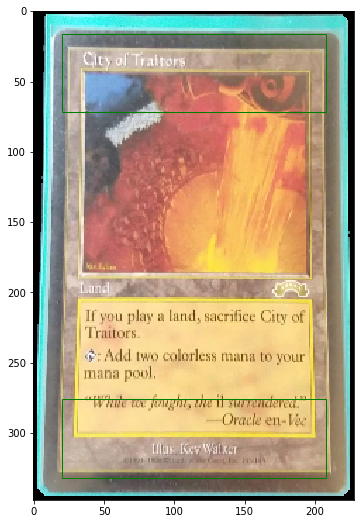

In [48]:
#Run a few times...
imgs_dir="data\\cards"
imgs_fns=glob(imgs_dir+"\\*\\*.png")
img_fn=random.choice(imgs_fns)
display_img(cv2.imread(img_fn,cv2.IMREAD_UNCHANGED),polygons=[refCornerHL,refCornerLR])

**Need to clean up zone space for text detection**

In [49]:
def findHull(img, corner=refCornerHL, debug="no"):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """
    
    kernel = np.ones((3,3),np.uint8)
    corner=corner.astype(np.int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()

    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    bilateral=cv2.bilateralFilter(gray,20,10,100)#<---added
    ret,thresh=cv2.threshold(bilateral,157,220,cv2.THRESH_TOZERO)#<----added
    thld=cv2.Canny(thresh,30,200)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug!="no": plt.imshow(thld)
    
    # Find the contours
    _,contours,_=cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=75 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.2 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        #print(hull_area)
        solidity = float(area)/hull_area#<----
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug != "no" :
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
        if debug != "no" and solidity <= min_solidity :
            print("Solidity",solidity)
            cv2.drawContours(strange_cnt,[c],0,255,2)
            plt.imshow(strange_cnt)
            
     
    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols   
        # We can now determine the hull
        hull=cv2.convexHull(concat_contour)
        hull_area=cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area=1000 # TWEAK, deck and 'zoom' dependant
        max_hull_area=10000 # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area: 
            ok=False
            if debug!="no":
                print("Hull area=",hull_area,"too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img' 
        hull_in_img=hull+corner[0]

    else:
        ok=False
    
    
    if debug != "no" :
        if concat_contour is not None:
            cv2.drawContours(zone,[hull],0,(0,255,0),1)
            cv2.drawContours(img,[hull_in_img],0,(0,255,0),1)
        plt.imshow(zone)
        plt.imshow(img)
        if ok and debug!="pause_always":
            key=cv2.waitKey(1)
        else:
            key=cv2.waitKey(0)
        if key==27:
            return None
    if ok == False:
        
        return None
    
    return hull_in_img

data\cards\Wooded_Foothills\318318915.png


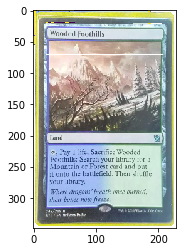

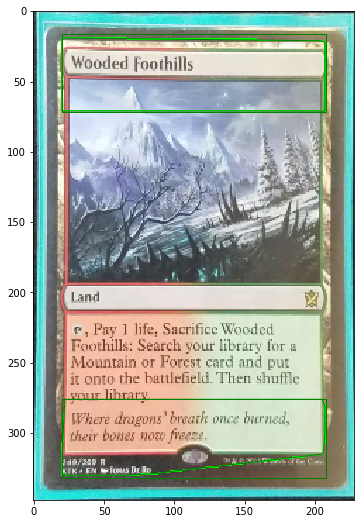

In [50]:
# Test find_hull on a random card image
# debug = "no" or "pause_always" or "pause_on_pb"
# If debug!="no", you may have to press a key to continue execution after pause
debug="yes" 
imgs_dir="data\\cards"
imgs_fns=glob(imgs_dir+"\\*\\*.png")
img_fn=random.choice(imgs_fns)
print(img_fn)
img=cv2.imread(img_fn,cv2.IMREAD_UNCHANGED)
hullHL=findHull(img,refCornerHL,debug=debug)
hullLR=findHull(img,refCornerLR,debug=debug)
display_img(img,[refCornerHL,refCornerLR,hullHL,hullLR])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [51]:
CardNames[:15]

['Ach_Hans_Run',
 'Rumors_of_My_Death',
 'World_Champion',
 'A_Display_of_My_Dark_Power',
 'A_Reckoning_Approaches',
 'AWOL',
 'Abandon_Hope',
 'Abandon_Reason',
 'Abandoned_Outpost',
 'Abandoned_Sarcophagus',
 'Abattoir_Ghoul',
 'Abbey_Gargoyles',
 'Abbey_Griffin',
 'Abbey_Matron',
 'Abbot_of_Keral_Keep']

In [52]:
imgs_dir="data\\cards"

cards={}
for card in CardNames:
    card_name=card        
    card_dir=os.path.join(imgs_dir,card_name)
    if not os.path.isdir(card_dir):
        #print("!!!",card_dir,"does not exist !!!")
        continue
    #cards[card_name]=[]
    for f in glob(card_dir+"\\*.png"):
        img=cv2.imread(f,cv2.IMREAD_UNCHANGED)
        hullHL=findHull(img,refCornerHL,debug="no") 
        if hullHL is None: 
            print("File:",f,"not used.")
            continue
        hullLR=findHull(img,refCornerLR,debug="no") 
        if hullLR is None: 
            #print("File:",f,"not used.")
            continue
        # We store the image in "rgb" format (we don't need opencv anymore)
        img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        #cards[card_name].append((img,hullHL,hullLR))
        cards[card_name]=((img,hullHL,hullLR))
#    print("Nb images for",CardNames,":",len(cards[card_name]))

File: data\cards\Ancient_Tomb\765495611.png not used.
File: data\cards\Brainstorm\004121925.png not used.
File: data\cards\Brainstorm\012959333.png not used.
File: data\cards\Brainstorm\033117839.png not used.
File: data\cards\Brainstorm\033504592.png not used.
File: data\cards\Brainstorm\040234965.png not used.
File: data\cards\Brainstorm\049006317.png not used.
File: data\cards\Brainstorm\071278755.png not used.
File: data\cards\Brainstorm\110871969.png not used.
File: data\cards\Brainstorm\159315119.png not used.
File: data\cards\Brainstorm\175959389.png not used.
File: data\cards\Brainstorm\206229105.png not used.
File: data\cards\Brainstorm\217711158.png not used.
File: data\cards\Brainstorm\232213398.png not used.
File: data\cards\Brainstorm\291008799.png not used.
File: data\cards\Brainstorm\297518973.png not used.
File: data\cards\Brainstorm\306405902.png not used.
File: data\cards\Brainstorm\315956292.png not used.
File: data\cards\Brainstorm\345896699.png not used.
File: data

In [53]:
cards.keys()

dict_keys(['Ancient_Tomb', 'Brainstorm', 'City_of_Traitors', 'Cunning_Wish', 'Emrakul_the_Aeons_Torn', 'Flusterstorm', 'Force_of_Will', 'Griselbrand', 'Intuition', 'Island', 'Lotus_Petal', 'Misty_Rainforest', 'Mountain', 'Omniscience', 'Polluted_Delta', 'Ponder', 'Scalding_Tarn', 'Show_and_Tell', 'Sneak_Attack', 'Spell_Pierce', 'Taiga', 'Volcanic_Island', 'Wooded_Foothills'])

In [54]:
cards['Island'][2]

array([[[138, 278]],

       [[128, 327]],

       [[120, 328]],

       [[ 98, 328]],

       [[ 97, 327]],

       [[ 97, 319]],

       [[109, 276]],

       [[138, 276]]])

In [55]:
print("Saved in :",cards_pck_fn)
pickle.dump(cards,open(cards_pck_fn,'wb'))

Saved in : data\cards.pck


In [56]:
class Cards():
    def __init__(self,cards_pck_fn=cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card,hull1,hull2=self._cards[card_name]#
        [random.randint(0,self._nb_cards_by_value[card_name]-1)]
        print(card_name)
        if display:
            if display: display_img(card,[hull1,hull2],"rgb")
        return card,card_name,hull1,hull2
    
cardlist = Cards()

Nb of cards loaded per name : {'Ancient_Tomb': 3, 'Brainstorm': 3, 'City_of_Traitors': 3, 'Cunning_Wish': 3, 'Emrakul_the_Aeons_Torn': 3, 'Flusterstorm': 3, 'Force_of_Will': 3, 'Griselbrand': 3, 'Intuition': 3, 'Island': 3, 'Lotus_Petal': 3, 'Misty_Rainforest': 3, 'Mountain': 3, 'Omniscience': 3, 'Polluted_Delta': 3, 'Ponder': 3, 'Scalding_Tarn': 3, 'Show_and_Tell': 3, 'Sneak_Attack': 3, 'Spell_Pierce': 3, 'Taiga': 3, 'Volcanic_Island': 3, 'Wooded_Foothills': 3}


Cunning_Wish


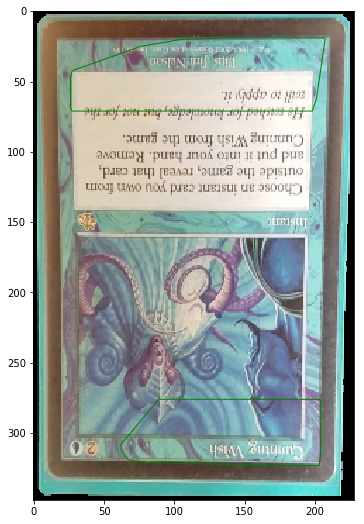

In [57]:
# Test: display a random card
_=cardlist.get_random(display=True)
#_=cards.get_random("As",display=True)

In [58]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)

In [59]:
# Scenario with 2 cards:
# The original image of a card has the shape (cardH,cardW,4)
# We first paste it in a zero image of shape (imgH,imgW,4) at position decalX, decalY
# so that the original image is centerd in the zero image
decalX=int((imgW-cardW)/2)      #((720-228)/2)=246
decalY=int((imgH-cardH)/2)      #((720-348)/2)=186

# Scenario with 3 cards : decal values are different
decalX3=int(imgW/2)#720/2=360
decalY3=int(imgH/2-cardH)#360-348=12


In [60]:
def kps_to_polygon(kps):
    """
        Convert imgaug keypoints to shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

In [61]:
def hull_to_kps(hull, decalX=decalX, decalY=decalY):
    """
        Convert hull to imgaug keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

In [62]:
def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)

In [63]:
# imgaug keypoints of the bounding box of a whole card
cardKP = ia.KeypointsOnImage([    
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),   
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))
    #Keypoint(x=-96.00000000, y=-336.00000000)
    #Keypoint(x=132.00000000, y=-336.00000000)
    #Keypoint(x=132.00000000, y=12.00000000)
    #Keypoint(x=-96.00000000, y=12.00000000)
    #shape=(720, 720, 3)

In [64]:
# imgaug transformation for one card in scenario with 2 cards
transform_1card = iaa.Sequential([
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),])

In [65]:
# For the 3 cards scenario, we use 3 imgaug transforms, the first 2 are for individual cards, 
# and the third one for the group of 3 cards
trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(22,30))])

trans_rot2 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (0, 5)}),
    iaa.Affine(rotate=(10,15))])

transform_3cards = iaa.Sequential([
    iaa.Affine(translate_px={"x":decalX-decalX3,"y":decalY-decalY3}),
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)})   ])

In [66]:
# imgaug transformation for the background
scaleBg=iaa.Scale({"height": imgH, "width": imgW})
scaleBg

Scale(name=UnnamedScale, parameters=[(Deterministic(int 720), Deterministic(int 720)), Deterministic(cubic)], deterministic=False)

In [67]:
def augment(img, list_kps, seq, restart=True):
    """
        Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
        If restart is False, the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    """ 
    # Make sequence deterministic
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]),kps_to_BB(list_kps_aug[2])]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid=False
                break
        if valid: break
        elif not restart:
            img_aug=None
            break
                
    return img_aug,list_kps_aug,list_bbs

In [68]:
class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname

In [69]:
#ValueError: could not broadcast input array from shape (348,228,4) into shape (336,96,4)
#-336 : -336+1392=1056,    -96:-96+912=816
#decalY:decalY+cardH,decalX:decalX+cardW,:

In [70]:
(imgH,imgW,4)

(720, 720, 4)

In [71]:
class Scene:
    def __init__(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3=None, class3=None,hulla3=None,hullb3=None):
        if img3 is not None:
            self.create3CardsScene(bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3, class3,hulla3,hullb3)
        else:
            self.create2CardsScene(bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2)

    def create2CardsScene(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2):
        kpsa1=hull_to_kps(hulla1)
        kpsb1=hull_to_kps(hullb1)
        kpsa2=hull_to_kps(hulla2)
        kpsb2=hull_to_kps(hullb2)
        
        # Randomly transform 1st card
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY:decalY+cardH,decalX:decalX+cardW,:]=img1#<-----
        self.img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],transform_1card)

        # Randomly transform 2nd card. We want that card 2 does not partially cover a corner of 1 card.
        # If so, we apply a new random transform to card 2
        while True:
            self.listbba=[]
            self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
            self.img2[decalY:decalY+cardH,decalX:decalX+cardW,:]=img2
            self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],transform_1card)

            # mainPoly2: shapely polygon of card 2
            mainPoly2=kps_to_polygon(self.lkps2[0].keypoints[0:4])
            invalid=False
            intersect_ratio=0.1
            for i in range(1,3):
                # smallPoly1: shapely polygon of one of the hull of card 1
                smallPoly1=kps_to_polygon(self.lkps1[i].keypoints[:])
                a=smallPoly1.area
                # We calculate area of the intersection of card 1 corner with card 2
                intersect=mainPoly2.intersection(smallPoly1)
                ai=intersect.area
                # If intersection area is small enough, we accept card 2
                if (a-ai)/a > 1-intersect_ratio:
                    self.listbba.append(BBA(self.bbs1[i-1],class1))
                # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                elif (a-ai)/a>intersect_ratio:
                    invalid=True
                    break
                    
            if not invalid: break
            
        self.class1=class1
        self.class2=class2
        for bb in self.bbs2:
            self.listbba.append(BBA(bb,class2))
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        mask2=self.img2[:,:,3]
        self.mask2=np.stack([mask2]*3,-1)
        self.final=np.where(self.mask2,self.img2[:,:,0:3],self.final)
        
        
        
    def create3CardsScene(self,bg,img1, class1, hulla1,hullb1,img2, class2,hulla2,hullb2,img3, class3,hulla3,hullb3):
        
        kpsa1=hull_to_kps(hulla1,decalX3,decalY3)
        kpsb1=hull_to_kps(hullb1,decalX3,decalY3)
        kpsa2=hull_to_kps(hulla2,decalX3,decalY3)
        kpsb2=hull_to_kps(hullb2,decalX3,decalY3)
        kpsa3=hull_to_kps(hulla3,decalX3,decalY3)
        kpsb3=hull_to_kps(hullb3,decalX3,decalY3)
        self.img3=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img3[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img3
        self.img3,self.lkps3,self.bbs3=augment(self.img3,[cardKP,kpsa3,kpsb3],trans_rot1)
        self.img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img2[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img2
        self.img2,self.lkps2,self.bbs2=augment(self.img2,[cardKP,kpsa2,kpsb2],trans_rot2)
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
        self.img1[decalY3:decalY3+cardH,decalX3:decalX3+cardW,:]=img1

        while True:
            det_transform_3cards = transform_3cards.to_deterministic()
            _img3,_lkps3,self.bbs3=augment(self.img3,self.lkps3,det_transform_3cards, False)
            if _img3 is None: continue
            _img2,_lkps2,self.bbs2=augment(self.img2,self.lkps2,det_transform_3cards, False)
            if _img2 is None: continue
            _img1,self.lkps1,self.bbs1=augment(self.img1,[cardKP,kpsa1,kpsb1],det_transform_3cards, False)
            if _img1 is None: continue
            break
            
        self.img3=_img3
        self.lkps3=_lkps3
        self.img2=_img2
        self.lkps2=_lkps2
        self.img1=_img1
        
        self.class1=class1
        self.class2=class2
        self.class3=class3
        self.listbba=[BBA(self.bbs1[0],class1),BBA(self.bbs2[0],class2),BBA(self.bbs3[0],class3),BBA(self.bbs3[1],class3)]
        
        # Construct final image of the scene by superimposing: bg, img1, img2 and img3
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
        mask2=self.img2[:,:,3]
        self.mask2=np.stack([mask2]*3,-1)
        self.final=np.where(self.mask2,self.img2[:,:,0:3],self.final)
        mask3=self.img3[:,:,3]
        self.mask3=np.stack([mask3]*3,-1)
        self.final=np.where(self.mask3,self.img3[:,:,0:3],self.final)

    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect=patches.Rectangle((bb.x1,bb.y1),bb.x2-bb.x1,bb.y2-bb.y1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
            
    def res(self):
        return self.final
    
    def write_files(self,save_dir,display=False):
        jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)

In [72]:
# Test generation of a scene with 2 cards
bg=backgrounds.get_random()

In [73]:
img1,card_val1,hulla1,hullb1=cardlist.get_random()

Wooded_Foothills


In [74]:
img2,card_val2,hulla2,hullb2=cardlist.get_random()

Island


In [82]:
newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)

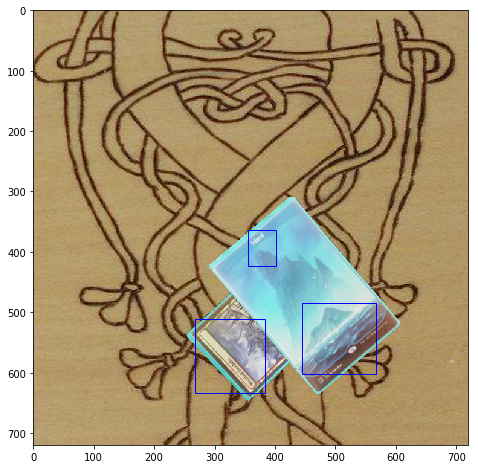

In [83]:
newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
newimg.display()

Intuition
Griselbrand
City_of_Traitors


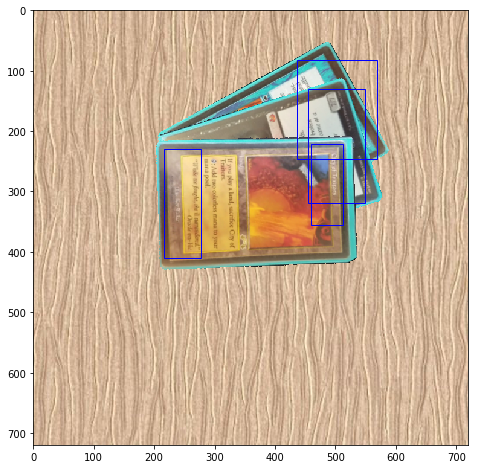

In [84]:
# Test generation of a scene with 3 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cardlist.get_random()
img2,card_val2,hulla2,hullb2=cardlist.get_random()
img3,card_val3,hulla3,hullb3=cardlist.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
newimg.display()

In [85]:
nb_cards_to_generate=100
save_dir="data\\scenes\\val"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cardlist.get_random()
    img2,card_val2,hulla2,hullb2=cardlist.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
    newimg.write_files(save_dir)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Cunning_Wish
Wooded_Foothills


  1%|▊                                                                                 | 1/100 [00:00<00:18,  5.46it/s]

Emrakul_the_Aeons_Torn
Mountain


  2%|█▋                                                                                | 2/100 [00:00<00:22,  4.37it/s]

Polluted_Delta
Mountain


  3%|██▍                                                                               | 3/100 [00:00<00:21,  4.51it/s]

Ponder
Wooded_Foothills


  4%|███▎                                                                              | 4/100 [00:00<00:20,  4.57it/s]

Polluted_Delta
Scalding_Tarn


  5%|████                                                                              | 5/100 [00:01<00:21,  4.41it/s]

City_of_Traitors
City_of_Traitors


  6%|████▉                                                                             | 6/100 [00:01<00:26,  3.51it/s]

Volcanic_Island
Volcanic_Island


  7%|█████▋                                                                            | 7/100 [00:01<00:23,  3.93it/s]

Cunning_Wish
Brainstorm


  8%|██████▌                                                                           | 8/100 [00:02<00:24,  3.76it/s]

Show_and_Tell
City_of_Traitors


  9%|███████▍                                                                          | 9/100 [00:02<00:22,  4.02it/s]

Lotus_Petal
City_of_Traitors


 10%|████████                                                                         | 10/100 [00:02<00:20,  4.37it/s]

Ponder
Ponder


 11%|████████▉                                                                        | 11/100 [00:02<00:18,  4.68it/s]

Spell_Pierce
Show_and_Tell


 12%|█████████▋                                                                       | 12/100 [00:02<00:19,  4.50it/s]

Sneak_Attack
Scalding_Tarn


 13%|██████████▌                                                                      | 13/100 [00:03<00:21,  4.08it/s]

Taiga
Scalding_Tarn


 14%|███████████▎                                                                     | 14/100 [00:03<00:20,  4.13it/s]

City_of_Traitors
Scalding_Tarn


 15%|████████████▏                                                                    | 15/100 [00:03<00:20,  4.23it/s]

Cunning_Wish
Griselbrand


 16%|████████████▉                                                                    | 16/100 [00:03<00:18,  4.48it/s]

Wooded_Foothills
Scalding_Tarn


 17%|█████████████▊                                                                   | 17/100 [00:04<00:18,  4.48it/s]

Polluted_Delta
Lotus_Petal


 18%|██████████████▌                                                                  | 18/100 [00:04<00:18,  4.33it/s]

Mountain
Cunning_Wish


 19%|███████████████▍                                                                 | 19/100 [00:04<00:17,  4.52it/s]

Volcanic_Island
Sneak_Attack


 20%|████████████████▏                                                                | 20/100 [00:04<00:19,  4.12it/s]

Scalding_Tarn
Island


 21%|█████████████████                                                                | 21/100 [00:04<00:17,  4.53it/s]

Polluted_Delta
Emrakul_the_Aeons_Torn


 22%|█████████████████▊                                                               | 22/100 [00:05<00:17,  4.46it/s]

Omniscience
Ponder


 23%|██████████████████▋                                                              | 23/100 [00:05<00:16,  4.61it/s]

Griselbrand
Cunning_Wish


 24%|███████████████████▍                                                             | 24/100 [00:05<00:15,  4.76it/s]

Cunning_Wish
Force_of_Will


 25%|████████████████████▎                                                            | 25/100 [00:05<00:14,  5.21it/s]

Ponder
Intuition


 26%|█████████████████████                                                            | 26/100 [00:05<00:15,  4.87it/s]

Taiga
Brainstorm


 27%|█████████████████████▊                                                           | 27/100 [00:06<00:16,  4.32it/s]

Brainstorm
Intuition


 28%|██████████████████████▋                                                          | 28/100 [00:06<00:15,  4.75it/s]

Misty_Rainforest
Sneak_Attack


 29%|███████████████████████▍                                                         | 29/100 [00:06<00:15,  4.55it/s]

Omniscience
Wooded_Foothills


 30%|████████████████████████▎                                                        | 30/100 [00:06<00:14,  4.89it/s]

Show_and_Tell
Taiga


 31%|█████████████████████████                                                        | 31/100 [00:07<00:13,  5.14it/s]

Mountain
Force_of_Will


 32%|█████████████████████████▉                                                       | 32/100 [00:07<00:12,  5.54it/s]

Emrakul_the_Aeons_Torn
Island


 33%|██████████████████████████▋                                                      | 33/100 [00:07<00:11,  5.87it/s]

Ancient_Tomb
Wooded_Foothills


 34%|███████████████████████████▌                                                     | 34/100 [00:07<00:10,  6.02it/s]

Lotus_Petal
Wooded_Foothills


 35%|████████████████████████████▎                                                    | 35/100 [00:07<00:10,  6.06it/s]

Misty_Rainforest
City_of_Traitors


 36%|█████████████████████████████▏                                                   | 36/100 [00:07<00:10,  6.06it/s]

Island
Brainstorm


 37%|█████████████████████████████▉                                                   | 37/100 [00:07<00:10,  6.14it/s]

Ancient_Tomb
Wooded_Foothills


 38%|██████████████████████████████▊                                                  | 38/100 [00:08<00:09,  6.26it/s]

Spell_Pierce
Island


 39%|███████████████████████████████▌                                                 | 39/100 [00:08<00:09,  6.20it/s]

Emrakul_the_Aeons_Torn
Omniscience


 40%|████████████████████████████████▍                                                | 40/100 [00:08<00:10,  5.75it/s]

Force_of_Will
Misty_Rainforest


 41%|█████████████████████████████████▏                                               | 41/100 [00:08<00:09,  6.01it/s]

City_of_Traitors
Volcanic_Island


 42%|██████████████████████████████████                                               | 42/100 [00:08<00:09,  5.84it/s]

Emrakul_the_Aeons_Torn
Ponder


 43%|██████████████████████████████████▊                                              | 43/100 [00:09<00:10,  5.52it/s]

Intuition
Scalding_Tarn


 44%|███████████████████████████████████▋                                             | 44/100 [00:09<00:09,  5.71it/s]

Omniscience
Flusterstorm


 45%|████████████████████████████████████▍                                            | 45/100 [00:09<00:09,  5.76it/s]

Flusterstorm
Misty_Rainforest


 46%|█████████████████████████████████████▎                                           | 46/100 [00:09<00:09,  5.62it/s]

Ponder
Lotus_Petal


 47%|██████████████████████████████████████                                           | 47/100 [00:09<00:09,  5.59it/s]

Volcanic_Island
City_of_Traitors


 48%|██████████████████████████████████████▉                                          | 48/100 [00:09<00:08,  5.86it/s]

Wooded_Foothills
Omniscience


 49%|███████████████████████████████████████▋                                         | 49/100 [00:10<00:08,  6.02it/s]

City_of_Traitors
Scalding_Tarn


 50%|████████████████████████████████████████▌                                        | 50/100 [00:10<00:08,  6.17it/s]

Omniscience
Griselbrand


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:10<00:08,  6.00it/s]

Misty_Rainforest
Sneak_Attack


 52%|██████████████████████████████████████████                                       | 52/100 [00:10<00:08,  5.90it/s]

Volcanic_Island
Lotus_Petal


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:10<00:07,  6.17it/s]

Emrakul_the_Aeons_Torn
Brainstorm


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:10<00:07,  6.14it/s]

Spell_Pierce
Ponder


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:11<00:08,  5.40it/s]

Emrakul_the_Aeons_Torn
Griselbrand


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:11<00:07,  5.71it/s]

Show_and_Tell
Mountain


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:11<00:07,  5.52it/s]

Spell_Pierce
Ancient_Tomb


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:11<00:07,  5.77it/s]

Ponder
Misty_Rainforest


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:11<00:08,  4.74it/s]

Sneak_Attack
Brainstorm


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:12<00:07,  5.06it/s]

Intuition
Taiga


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:12<00:07,  5.42it/s]

Spell_Pierce
Volcanic_Island


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:12<00:07,  5.15it/s]

Show_and_Tell
Show_and_Tell


 63%|███████████████████████████████████████████████████                              | 63/100 [00:12<00:06,  5.39it/s]

Sneak_Attack
City_of_Traitors


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:12<00:06,  5.40it/s]

Brainstorm
Island


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:12<00:06,  5.35it/s]

Sneak_Attack
Intuition


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:13<00:06,  5.37it/s]

Cunning_Wish
Cunning_Wish


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:13<00:05,  5.69it/s]

Ponder
Scalding_Tarn


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:13<00:05,  5.92it/s]

City_of_Traitors
Griselbrand


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:13<00:05,  5.21it/s]

Wooded_Foothills
Polluted_Delta


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:13<00:05,  5.44it/s]

Island
Wooded_Foothills


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:13<00:05,  5.75it/s]

Griselbrand
Volcanic_Island


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:14<00:04,  5.94it/s]

Scalding_Tarn
Mountain


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:14<00:04,  5.98it/s]

Misty_Rainforest
Brainstorm


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:14<00:04,  5.56it/s]

Scalding_Tarn
Volcanic_Island


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:14<00:04,  5.75it/s]

Lotus_Petal
Island


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:14<00:04,  5.90it/s]

Ponder
Volcanic_Island


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:15<00:03,  5.89it/s]

Scalding_Tarn
Omniscience


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:15<00:03,  6.09it/s]

Mountain
Emrakul_the_Aeons_Torn


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:15<00:03,  5.72it/s]

Griselbrand
Flusterstorm


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:15<00:03,  5.87it/s]

Cunning_Wish
Cunning_Wish


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:15<00:03,  5.63it/s]

Cunning_Wish
Wooded_Foothills


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:15<00:03,  5.50it/s]

Taiga
Omniscience


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:16<00:02,  5.73it/s]

Taiga
Griselbrand


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:16<00:03,  4.59it/s]

Flusterstorm
City_of_Traitors


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:16<00:02,  5.06it/s]

Wooded_Foothills
Show_and_Tell


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:16<00:02,  5.24it/s]

Brainstorm
Spell_Pierce


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:16<00:02,  5.07it/s]

Volcanic_Island
Mountain


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:17<00:02,  5.39it/s]

Omniscience
Spell_Pierce


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:17<00:02,  5.48it/s]

Griselbrand
Volcanic_Island


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:17<00:01,  5.58it/s]

Ancient_Tomb
Wooded_Foothills


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:17<00:01,  5.56it/s]

Force_of_Will
Intuition


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:17<00:01,  5.60it/s]

Polluted_Delta
Cunning_Wish


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:18<00:01,  5.22it/s]

Omniscience
Griselbrand


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:18<00:01,  5.33it/s]

Wooded_Foothills
City_of_Traitors


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:18<00:00,  5.47it/s]

Taiga
Mountain


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:18<00:00,  5.36it/s]

Lotus_Petal
Polluted_Delta


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:18<00:00,  5.28it/s]

Flusterstorm
Griselbrand


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:19<00:00,  4.70it/s]

Cunning_Wish
Brainstorm


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:19<00:00,  4.73it/s]

Volcanic_Island
Lotus_Petal


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  4.94it/s]


In [86]:
nb_cards_to_generate=100
save_dir="data\\scenes\\val"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg=backgrounds.get_random()
    img1,card_val1,hulla1,hullb1=cardlist.get_random()
    img2,card_val2,hulla2,hullb2=cardlist.get_random()
    img3,card_val3,hulla3,hullb3=cardlist.get_random()
    
    newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
    newimg.write_files(save_dir)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Show_and_Tell
Ponder
Wooded_Foothills


  1%|▊                                                                                 | 1/100 [00:00<00:30,  3.27it/s]

Polluted_Delta
Intuition
Show_and_Tell


  2%|█▋                                                                                | 2/100 [00:00<00:28,  3.46it/s]

Intuition
Scalding_Tarn
Show_and_Tell


  3%|██▍                                                                               | 3/100 [00:00<00:26,  3.63it/s]

Spell_Pierce
Emrakul_the_Aeons_Torn
Polluted_Delta


  4%|███▎                                                                              | 4/100 [00:01<00:26,  3.67it/s]

Force_of_Will
Lotus_Petal
Polluted_Delta


  5%|████                                                                              | 5/100 [00:01<00:26,  3.54it/s]

Flusterstorm
Mountain
Polluted_Delta


  6%|████▉                                                                             | 6/100 [00:01<00:28,  3.35it/s]

Mountain
Show_and_Tell
Spell_Pierce


  7%|█████▋                                                                            | 7/100 [00:01<00:26,  3.51it/s]

Polluted_Delta
Cunning_Wish
Ponder


  8%|██████▌                                                                           | 8/100 [00:02<00:25,  3.64it/s]

Emrakul_the_Aeons_Torn
Spell_Pierce
Taiga


  9%|███████▍                                                                          | 9/100 [00:02<00:25,  3.51it/s]

Misty_Rainforest
Sneak_Attack
Spell_Pierce


 10%|████████                                                                         | 10/100 [00:02<00:25,  3.53it/s]

Scalding_Tarn
Sneak_Attack
Spell_Pierce


 11%|████████▉                                                                        | 11/100 [00:03<00:25,  3.54it/s]

City_of_Traitors
Island
Spell_Pierce


 12%|█████████▋                                                                       | 12/100 [00:03<00:24,  3.61it/s]

Show_and_Tell
Intuition
Island


 13%|██████████▌                                                                      | 13/100 [00:03<00:24,  3.62it/s]

Island
Mountain
Flusterstorm


 14%|███████████▎                                                                     | 14/100 [00:03<00:23,  3.61it/s]

Force_of_Will
Taiga
Sneak_Attack


 15%|████████████▏                                                                    | 15/100 [00:04<00:24,  3.42it/s]

Mountain
Brainstorm
Ponder


 16%|████████████▉                                                                    | 16/100 [00:04<00:25,  3.28it/s]

Spell_Pierce
Omniscience
Misty_Rainforest


 17%|█████████████▊                                                                   | 17/100 [00:04<00:24,  3.34it/s]

Island
Mountain
Ponder


 18%|██████████████▌                                                                  | 18/100 [00:05<00:22,  3.58it/s]

Scalding_Tarn
Spell_Pierce
Lotus_Petal


 19%|███████████████▍                                                                 | 19/100 [00:05<00:21,  3.76it/s]

Show_and_Tell
Wooded_Foothills
Griselbrand


 20%|████████████████▏                                                                | 20/100 [00:05<00:21,  3.66it/s]

Mountain
Polluted_Delta
Intuition


 21%|█████████████████                                                                | 21/100 [00:05<00:21,  3.71it/s]

Island
Force_of_Will
Taiga


 22%|█████████████████▊                                                               | 22/100 [00:06<00:20,  3.89it/s]

Spell_Pierce
Griselbrand
Cunning_Wish


 23%|██████████████████▋                                                              | 23/100 [00:06<00:19,  3.99it/s]

Spell_Pierce
Ponder
Island


 24%|███████████████████▍                                                             | 24/100 [00:06<00:18,  4.09it/s]

Wooded_Foothills
Mountain
Show_and_Tell


 25%|████████████████████▎                                                            | 25/100 [00:06<00:18,  4.03it/s]

Griselbrand
Ancient_Tomb
Scalding_Tarn


 26%|█████████████████████                                                            | 26/100 [00:07<00:18,  4.10it/s]

Sneak_Attack
Intuition
Polluted_Delta


 27%|█████████████████████▊                                                           | 27/100 [00:07<00:17,  4.15it/s]

Cunning_Wish
City_of_Traitors
Ponder


 28%|██████████████████████▋                                                          | 28/100 [00:07<00:17,  4.17it/s]

Spell_Pierce
Flusterstorm
Volcanic_Island


 29%|███████████████████████▍                                                         | 29/100 [00:07<00:16,  4.18it/s]

Mountain
Spell_Pierce
Emrakul_the_Aeons_Torn


 30%|████████████████████████▎                                                        | 30/100 [00:07<00:16,  4.24it/s]

Misty_Rainforest
Sneak_Attack
Island


 31%|█████████████████████████                                                        | 31/100 [00:08<00:16,  4.28it/s]

Spell_Pierce
Ponder
Scalding_Tarn


 32%|█████████████████████████▉                                                       | 32/100 [00:08<00:16,  4.03it/s]

City_of_Traitors
Taiga
Polluted_Delta


 33%|██████████████████████████▋                                                      | 33/100 [00:08<00:16,  4.09it/s]

Mountain
Ponder
Emrakul_the_Aeons_Torn


 34%|███████████████████████████▌                                                     | 34/100 [00:08<00:16,  4.08it/s]

Emrakul_the_Aeons_Torn
Wooded_Foothills
Mountain


 35%|████████████████████████████▎                                                    | 35/100 [00:09<00:15,  4.19it/s]

Taiga
Misty_Rainforest
Emrakul_the_Aeons_Torn


 36%|█████████████████████████████▏                                                   | 36/100 [00:09<00:15,  4.10it/s]

Ancient_Tomb
Island
Volcanic_Island


 37%|█████████████████████████████▉                                                   | 37/100 [00:09<00:15,  4.18it/s]

City_of_Traitors
Flusterstorm
Griselbrand


 38%|██████████████████████████████▊                                                  | 38/100 [00:09<00:15,  4.13it/s]

City_of_Traitors
Emrakul_the_Aeons_Torn
Force_of_Will


 39%|███████████████████████████████▌                                                 | 39/100 [00:10<00:14,  4.14it/s]

Island
Ponder
Polluted_Delta


 40%|████████████████████████████████▍                                                | 40/100 [00:10<00:14,  4.18it/s]

Omniscience
Mountain
Show_and_Tell


 41%|█████████████████████████████████▏                                               | 41/100 [00:10<00:15,  3.91it/s]

Sneak_Attack
Ancient_Tomb
Emrakul_the_Aeons_Torn


 42%|██████████████████████████████████                                               | 42/100 [00:10<00:15,  3.84it/s]

Show_and_Tell
Scalding_Tarn
Taiga


 43%|██████████████████████████████████▊                                              | 43/100 [00:11<00:14,  3.99it/s]

Flusterstorm
Force_of_Will
Polluted_Delta


 44%|███████████████████████████████████▋                                             | 44/100 [00:11<00:13,  4.08it/s]

Flusterstorm
Spell_Pierce
Taiga


 45%|████████████████████████████████████▍                                            | 45/100 [00:11<00:13,  4.14it/s]

Misty_Rainforest
Taiga
Brainstorm


 46%|█████████████████████████████████████▎                                           | 46/100 [00:11<00:12,  4.20it/s]

Island
Griselbrand
Sneak_Attack


 47%|██████████████████████████████████████                                           | 47/100 [00:12<00:13,  4.05it/s]

Island
Brainstorm
Cunning_Wish


 48%|██████████████████████████████████████▉                                          | 48/100 [00:12<00:12,  4.14it/s]

Lotus_Petal
Island
Misty_Rainforest


 49%|███████████████████████████████████████▋                                         | 49/100 [00:12<00:12,  4.23it/s]

Sneak_Attack
Flusterstorm
Flusterstorm


 50%|████████████████████████████████████████▌                                        | 50/100 [00:12<00:11,  4.29it/s]

Mountain
Show_and_Tell
Sneak_Attack


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:13<00:11,  4.30it/s]

Scalding_Tarn
Polluted_Delta
Sneak_Attack


 52%|██████████████████████████████████████████                                       | 52/100 [00:13<00:11,  4.34it/s]

Griselbrand
Brainstorm
Ancient_Tomb


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:13<00:10,  4.31it/s]

Mountain
Island
Lotus_Petal


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:13<00:11,  3.96it/s]

Ponder
Spell_Pierce
Intuition


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:14<00:11,  3.97it/s]

Mountain
Misty_Rainforest
Mountain


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:14<00:10,  4.03it/s]

Taiga
Taiga
Show_and_Tell


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:14<00:10,  4.16it/s]

Spell_Pierce
Lotus_Petal
Ancient_Tomb


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:14<00:10,  3.82it/s]

Ancient_Tomb
Lotus_Petal
Mountain


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:15<00:10,  3.98it/s]

Taiga
Cunning_Wish
Spell_Pierce


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:15<00:09,  4.09it/s]

Mountain
City_of_Traitors
Polluted_Delta


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:15<00:09,  4.19it/s]

City_of_Traitors
Omniscience
Force_of_Will


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:15<00:09,  4.21it/s]

Wooded_Foothills
Flusterstorm
Cunning_Wish


 63%|███████████████████████████████████████████████████                              | 63/100 [00:16<00:08,  4.24it/s]

Ponder
Ponder
Show_and_Tell


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:16<00:08,  4.27it/s]

Lotus_Petal
Volcanic_Island
Island


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:16<00:08,  4.18it/s]

Misty_Rainforest
Brainstorm
Show_and_Tell


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:16<00:08,  4.19it/s]

Sneak_Attack
Spell_Pierce
Intuition


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:16<00:07,  4.29it/s]

Show_and_Tell
Ponder
Ponder


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:17<00:07,  4.32it/s]

Misty_Rainforest
Island
Lotus_Petal


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:17<00:07,  4.32it/s]

City_of_Traitors
Sneak_Attack
Cunning_Wish


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:17<00:07,  4.14it/s]

Taiga
Force_of_Will
Force_of_Will


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:17<00:07,  4.13it/s]

Force_of_Will
Omniscience
Emrakul_the_Aeons_Torn


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:18<00:06,  4.12it/s]

Misty_Rainforest
Cunning_Wish
Polluted_Delta


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:18<00:06,  4.05it/s]

Polluted_Delta
Show_and_Tell
Omniscience


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:18<00:06,  4.08it/s]

Ancient_Tomb
Emrakul_the_Aeons_Torn
Wooded_Foothills


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:18<00:06,  4.06it/s]

Ponder
Ponder
Cunning_Wish


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:19<00:05,  4.14it/s]

Flusterstorm
Island
Brainstorm


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:19<00:06,  3.83it/s]

Ancient_Tomb
Mountain
Lotus_Petal


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:19<00:05,  3.96it/s]

Omniscience
Cunning_Wish
Sneak_Attack


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:19<00:05,  4.08it/s]

Force_of_Will
Griselbrand
Ponder


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:20<00:04,  4.12it/s]

Omniscience
Brainstorm
Omniscience


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:20<00:04,  4.13it/s]

Taiga
Lotus_Petal
Omniscience


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:20<00:04,  4.06it/s]

Volcanic_Island
Mountain
Misty_Rainforest


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:20<00:04,  4.21it/s]

Griselbrand
Show_and_Tell
Force_of_Will


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:21<00:03,  4.23it/s]

Emrakul_the_Aeons_Torn
Sneak_Attack
Show_and_Tell


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:21<00:03,  4.22it/s]

Emrakul_the_Aeons_Torn
Intuition
Emrakul_the_Aeons_Torn


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:21<00:03,  4.29it/s]

Intuition
Mountain
Ponder


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:21<00:03,  4.27it/s]

Volcanic_Island
Mountain
Flusterstorm


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:22<00:02,  4.26it/s]

Cunning_Wish
Intuition
Brainstorm


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:22<00:02,  4.04it/s]

Griselbrand
Flusterstorm
Island


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:22<00:02,  4.09it/s]

Spell_Pierce
Show_and_Tell
Taiga


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:22<00:02,  4.09it/s]

Emrakul_the_Aeons_Torn
Show_and_Tell
Griselbrand


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:23<00:01,  4.17it/s]

Omniscience
Mountain
Island


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:23<00:01,  4.08it/s]

Intuition
City_of_Traitors
Polluted_Delta


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:23<00:01,  4.03it/s]

Flusterstorm
Show_and_Tell
Mountain


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:23<00:01,  4.08it/s]

Griselbrand
Volcanic_Island
Island


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:24<00:00,  4.07it/s]

Spell_Pierce
Flusterstorm
Force_of_Will


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:24<00:00,  3.90it/s]

Lotus_Petal
Ancient_Tomb
Misty_Rainforest


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:24<00:00,  3.75it/s]

Force_of_Will
Misty_Rainforest
City_of_Traitors


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:24<00:00,  3.90it/s]

Force_of_Will
Griselbrand
Spell_Pierce


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  4.04it/s]
